In [5]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from keras.api._v2 import keras
from keras.api._v2.keras import layers
from keras.api._v2.keras import Sequential
from keras.api._v2.keras.preprocessing.image import load_img
from keras.api._v2.keras.preprocessing.image import ImageDataGenerator
from keras.api._v2.keras.applications import xception
from keras.api._v2.keras.metrics import sparse_categorical_accuracy
from keras.api._v2.keras.metrics import categorical_accuracy
import pandas as pd

Dataset from https://github.com/alexeygrigorev/clothing-dataset-small

## Using pretrained model Xception

In [3]:
aimage='../data/clothing-dataset-small/train/t-shirt/5f0a3fa0-6a3d-4b68-b213-72766a643de7.jpg'
img = np.array(load_img(aimage, target_size=(299, 299)))
X = np.array([img])

In [6]:
model = xception.Xception(weights='imagenet', input_shape=(299, 299, 3))

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-08-16 13:02:22.517037: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-16 13:02:22.517689: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


91884032/91884032 [==============================] - 7s 0us/step


In [7]:
y_hat = model.predict(xception.preprocess_input(X))
xception.decode_predictions(y_hat)

2022-08-16 13:02:34.155532: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-16 13:02:34.449329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


35363/35363 [==============================] - 0s 0us/step


[[('n03595614', 'jersey', 0.6819641),
  ('n02916936', 'bulletproof_vest', 0.03813984),
  ('n04370456', 'sweatshirt', 0.034324724),
  ('n03710637', 'maillot', 0.0113542145),
  ('n04525038', 'velvet', 0.0018453562)]]

The imagenet doen't have a category called T-shirt

## 0. Preparing dataset

according to the official doc. `ImageDataGenerator` is deprecated, so use the suggested alternative `keras.utils.image_dataset_from_directory`

we'll apply data augmentation on training set, so only apply image scaling on validation and test set.

In [9]:
train_ds = keras.utils.image_dataset_from_directory(
    '../data/clothing-dataset-small/train/',
    image_size=(150, 150),
    batch_size=32,
    shuffle=True,
    label_mode='categorical',
)
classes = train_ds.class_names
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 3068 files belonging to 10 classes.


In [10]:
val_ds = keras.utils.image_dataset_from_directory(
    '../data/clothing-dataset-small/validation/',
    image_size=(150, 150),
    batch_size=32,
    shuffle=False,
    label_mode='categorical',
).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (xception.preprocess_input(x), y))

Found 341 files belonging to 10 classes.


In [11]:
test_ds = keras.utils.image_dataset_from_directory(
    '../data/clothing-dataset-small/test/',
    image_size=(150, 150),
    batch_size=32,
    shuffle=False,
    label_mode='categorical',
).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (xception.preprocess_input(x), y))

Found 372 files belonging to 10 classes.


## 1. drop the last layer(top) to use our own own

layers stores in a stack. so top is the final output layer in the original model.

use `keras.Sequential` as much as possible because it's self-explained and looks clean.

Baseline, it's a overfitting model

In [12]:
class WrappedXception(layers.Layer):
    def __init__(self, **kwargs):
        super(WrappedXception, self).__init__(**kwargs)
        self.base_model = xception.Xception(
            weights='imagenet',
            include_top=False,
            input_shape=(150, 150, 3)
        )
        self.base_model.trainable = False

    def call(self, x, training):
        return self.base_model(x, training=False)

Average pooling

In [14]:
def make_model(post_layers, learning_rate=0.001):
    model = keras.Sequential([
        WrappedXception(),
        layers.GlobalAveragePooling2D(),
        post_layers
    ])
    model.compile(
        loss=keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    return model

In [15]:
model = make_model(Sequential(
    [layers.Dense(10, activation='linear')]
))
history = model.fit(train_ds.map(lambda x, y: (xception.preprocess_input(x), y)),
    epochs=10,
    validation_data=val_ds
)

83683744/83683744 [==============================] - 6s 0us/step
Epoch 1/10


2022-08-16 13:05:37.698014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - ETA: 0s - loss: 1.3613 - accuracy: 0.6353

2022-08-16 13:05:49.864882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - 15s 138ms/step - loss: 1.3613 - accuracy: 0.6353 - val_loss: 1.0856 - val_accuracy: 0.7742
Epoch 2/10
96/96 [==============================] - 12s 129ms/step - loss: 1.0117 - accuracy: 0.7891 - val_loss: 1.0341 - val_accuracy: 0.7830
Epoch 3/10
96/96 [==============================] - 12s 129ms/step - loss: 0.9263 - accuracy: 0.8370 - val_loss: 1.0032 - val_accuracy: 0.8035
Epoch 4/10
96/96 [==============================] - 13s 130ms/step - loss: 0.8677 - accuracy: 0.8693 - val_loss: 0.9811 - val_accuracy: 0.8240
Epoch 5/10
96/96 [==============================] - 12s 128ms/step - loss: 0.8271 - accuracy: 0.8996 - val_loss: 0.9985 - val_accuracy: 0.7977
Epoch 6/10
96/96 [==============================] - 12s 129ms/step - loss: 0.7938 - accuracy: 0.9136 - val_loss: 0.9764 - val_accuracy: 0.8358
Epoch 7/10
96/96 [==============================] - 13s 130ms/step - loss: 0.7648 - accuracy: 0.9299 - val_loss: 0.9770 - val_accuracy: 0.8270
Epoch 8/10

In [16]:
df_history = pd.DataFrame(history.history)
df_history

,loss,accuracy,val_loss,val_accuracy
0,1.361271,0.635267,1.085559,0.774194
1,1.011693,0.789113,1.034063,0.782991
2,0.926253,0.837027,1.003169,0.803519
3,0.867695,0.869296,0.981089,0.824047
4,0.827064,0.899609,0.998454,0.797654
5,0.793771,0.913624,0.976398,0.835777
6,0.764761,0.929922,0.976989,0.826979
7,0.743397,0.945241,0.985074,0.818182
8,0.724030,0.951760,0.980401,0.818182
9,0.710242,0.954368,0.983225,0.815249


In [57]:
df_history.rename_axis('epoch').reset_index().melt(id_vars='epoch', value_vars=['accuracy', 'val_accuracy',]).head(20)

,epoch,variable,value
0,0,accuracy,0.635267
1,1,accuracy,0.789113
2,2,accuracy,0.837027
3,3,accuracy,0.869296
4,4,accuracy,0.899609
5,5,accuracy,0.913624
6,6,accuracy,0.929922
7,7,accuracy,0.945241
8,8,accuracy,0.951760
9,9,accuracy,0.954368


<AxesSubplot:xlabel='epoch', ylabel='%'>

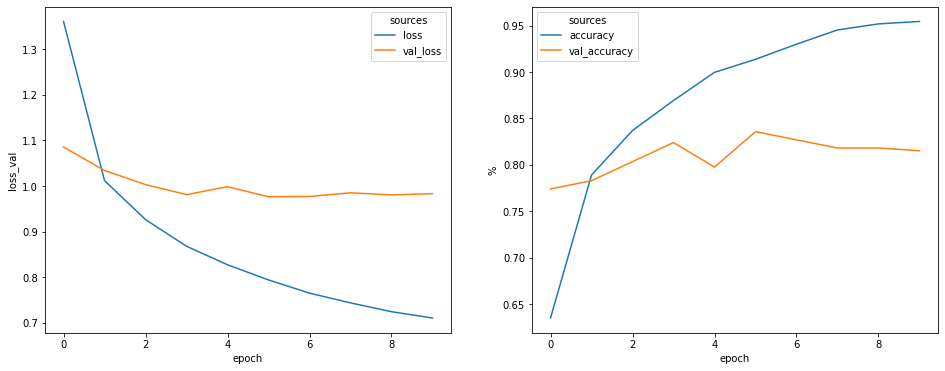

In [62]:
loss_df = df_history.filter(regex='loss', axis=1).rename_axis('epoch').reset_index().melt(id_vars='epoch', var_name='sources', value_name='loss_val')
acc_df = df_history.filter(regex='accuracy', axis=1).rename_axis('epoch').reset_index().melt(id_vars='epoch', var_name='sources', value_name='%')
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.lineplot(data=loss_df, x='epoch', y='loss_val', hue='sources', ax=axes[0])
sns.lineplot(data=acc_df, x='epoch', y='%', hue='sources', ax=axes[1])

Add droupout or regularization

dropout doesn't make any change.

l2 with alpha 0.01 makes train and val set closer.

In [196]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_acc:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [753]:
model = make_model(Sequential([
    layers.Dense(10, activation='linear', kernel_regularizer=keras.regularizers.l2(0.001)),
]))

history = model.fit(train_ds.map(lambda x, y: (xception.preprocess_input(x), y)),
    epochs=10,
    validation_data=val_ds
)

Epoch 1/10


2022-08-13 22:12:54.247675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - ETA: 0s - loss: 1.4343 - accuracy: 0.6581

2022-08-13 22:13:09.594100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - 21s 180ms/step - loss: 1.4343 - accuracy: 0.6581 - val_loss: 0.9529 - val_accuracy: 0.7595
Epoch 2/10
96/96 [==============================] - 13s 136ms/step - loss: 0.8437 - accuracy: 0.8005 - val_loss: 1.4023 - val_accuracy: 0.7566
Epoch 3/10
96/96 [==============================] - 13s 135ms/step - loss: 0.7104 - accuracy: 0.8432 - val_loss: 1.2321 - val_accuracy: 0.7419
Epoch 4/10
96/96 [==============================] - 13s 133ms/step - loss: 0.5801 - accuracy: 0.8924 - val_loss: 1.1142 - val_accuracy: 0.8035
Epoch 5/10
96/96 [==============================] - 13s 135ms/step - loss: 0.5611 - accuracy: 0.9016 - val_loss: 1.1025 - val_accuracy: 0.7859
Epoch 6/10
96/96 [==============================] - 13s 136ms/step - loss: 0.6155 - accuracy: 0.8980 - val_loss: 1.2298 - val_accuracy: 0.7595
Epoch 7/10
96/96 [==============================] - 13s 136ms/step - loss: 0.5652 - accuracy: 0.9188 - val_loss: 1.2869 - val_accuracy: 0.7595
Epoch 8/10

In [754]:
df_history = pd.DataFrame(history.history)

<AxesSubplot:xlabel='epoch', ylabel='%'>

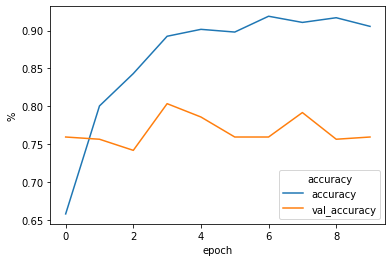

In [755]:
dfm = pd.melt(df_history.reset_index().rename(columns={'index': 'epoch'}), id_vars='epoch', value_vars=['accuracy', 'val_accuracy'], var_name='accuracy', value_name='%')
sns.lineplot(data=dfm, x='epoch', y='%', hue='accuracy')

Data Augmentation

in MAC, these transformation has to do in CPU

In [15]:
with tf.device('/cpu:0'):
    data_augmentation = keras.Sequential([
        keras.layers.RandomRotation(40),
        keras.layers.RandomTranslation(0, 0.2),
        keras.layers.RandomTranslation(0.2, 0),
        keras.layers.RandomZoom(0.2, 0.2),
        keras.layers.RandomFlip(mode='horizontal'),
        keras.layers.Lambda(xception.preprocess_input)
    ])

In [757]:
post_layers = Sequential([
    layers.Dropout(rate=0.2),
    layers.Dense(10, activation='linear'),
])
model = make_model(post_layers, learning_rate=0.001)

history = model.fit(train_ds.map(lambda x, y: (data_augmentation(x), y)),
    epochs=10,
    validation_data=val_ds
)

Epoch 1/10


2022-08-13 22:18:16.492933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - ETA: 0s - loss: 1.1360 - accuracy: 0.6033

2022-08-13 22:18:32.095447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - 23s 186ms/step - loss: 1.1360 - accuracy: 0.6033 - val_loss: 0.7429 - val_accuracy: 0.7507
Epoch 2/10
96/96 [==============================] - 13s 137ms/step - loss: 0.6747 - accuracy: 0.7656 - val_loss: 0.6511 - val_accuracy: 0.7771
Epoch 3/10
96/96 [==============================] - 13s 136ms/step - loss: 0.5583 - accuracy: 0.8057 - val_loss: 0.6154 - val_accuracy: 0.7918
Epoch 4/10
96/96 [==============================] - 13s 137ms/step - loss: 0.4815 - accuracy: 0.8380 - val_loss: 0.5920 - val_accuracy: 0.8094
Epoch 5/10
96/96 [==============================] - 13s 137ms/step - loss: 0.4245 - accuracy: 0.8537 - val_loss: 0.5760 - val_accuracy: 0.8123
Epoch 6/10
96/96 [==============================] - 13s 135ms/step - loss: 0.3732 - accuracy: 0.8820 - val_loss: 0.5742 - val_accuracy: 0.8123
Epoch 7/10
96/96 [==============================] - 13s 135ms/step - loss: 0.3375 - accuracy: 0.8999 - val_loss: 0.5626 - val_accuracy: 0.8152
Epoch 8/10

<AxesSubplot:xlabel='epoch', ylabel='%'>

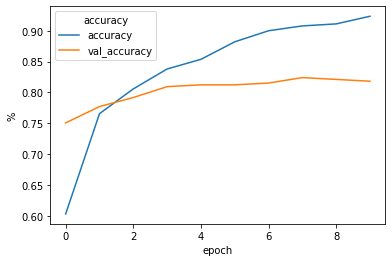

In [758]:
df_history = pd.DataFrame(history.history)
dfm = pd.melt(df_history.reset_index().rename(columns={'index': 'epoch'}), id_vars='epoch', value_vars=['accuracy', 'val_accuracy'], var_name='accuracy', value_name='%')
sns.lineplot(data=dfm, x='epoch', y='%', hue='accuracy')

## Predict on test set

In [790]:
y_hat = model.predict(test_ds)

12/12 [==============================] - 2s 139ms/step


In [791]:
test_label = np.concatenate([y for x, y in test_ds], axis=0)

In [849]:
model.evaluate(test_ds)

12/12 [==============================] - 6s 408ms/step - loss: 0.8520 - accuracy: 0.7957


[0.8520011305809021, 0.7956989407539368]

OK, consist with validation set.

## Further fine tuning
retrain top k layers of base model. This should only apply when we've found some parameters to converge our previous model.

In [58]:
post_layers = Sequential([
    layers.Dropout(rate=0.2),
    layers.Dense(10, activation='linear'),
])
model = make_model(post_layers, learning_rate=0.001)

history = model.fit(train_ds.map(lambda x, y: (data_augmentation(x), y)),
    epochs=10,
    validation_data=val_ds
)

Epoch 1/10


2022-08-14 10:11:03.755036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - ETA: 0s - loss: 1.4080 - accuracy: 0.6151

2022-08-14 10:11:16.099087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - 16s 141ms/step - loss: 1.4080 - accuracy: 0.6151 - val_loss: 1.0990 - val_accuracy: 0.7683
Epoch 2/10
96/96 [==============================] - 13s 136ms/step - loss: 1.0536 - accuracy: 0.7744 - val_loss: 1.0350 - val_accuracy: 0.7977
Epoch 3/10
96/96 [==============================] - 12s 129ms/step - loss: 0.9718 - accuracy: 0.8054 - val_loss: 1.0024 - val_accuracy: 0.8006
Epoch 4/10
96/96 [==============================] - 13s 130ms/step - loss: 0.9157 - accuracy: 0.8452 - val_loss: 0.9921 - val_accuracy: 0.7977
Epoch 5/10
96/96 [==============================] - 12s 130ms/step - loss: 0.8720 - accuracy: 0.8699 - val_loss: 0.9825 - val_accuracy: 0.8123
Epoch 6/10
96/96 [==============================] - 13s 130ms/step - loss: 0.8383 - accuracy: 0.8853 - val_loss: 0.9777 - val_accuracy: 0.8299
Epoch 7/10
96/96 [==============================] - 13s 130ms/step - loss: 0.8124 - accuracy: 0.9051 - val_loss: 0.9674 - val_accuracy: 0.8299
Epoch 8/10

<AxesSubplot:xlabel='epoch', ylabel='%'>

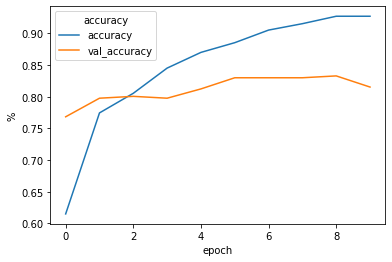

In [59]:
df_history = pd.DataFrame(history.history)
dfm = pd.melt(df_history.reset_index().rename(columns={'index': 'epoch'}), id_vars='epoch', value_vars=['accuracy', 'val_accuracy'], var_name='accuracy', value_name='%')
sns.lineplot(data=dfm, x='epoch', y='%', hue='accuracy')

base model has 132 layers, I fixed the bottom 100, only train the top 32 layers.

In [60]:
model.layers[0].base_model.trainable = True
for layer in model.layers[0].base_model.layers[:100]:
    layer.trainable = False

model.compile(
    loss=keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [61]:
fine_tune_epochs=10
total_epochs = 20
history_fine = model.fit(train_ds.map(lambda x, y: (data_augmentation(x), y)),
    epochs=20,
    initial_epoch=history.epoch[-1], # should +1 here, or it will run 11 times like the log.
    validation_data=val_ds
)

Epoch 10/20


2022-08-14 10:14:00.505441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - ETA: 0s - loss: 1.4605 - accuracy: 0.6017

2022-08-14 10:14:17.900226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - 21s 193ms/step - loss: 1.4605 - accuracy: 0.6017 - val_loss: 0.9030 - val_accuracy: 0.8270
Epoch 11/20
96/96 [==============================] - 18s 184ms/step - loss: 0.8365 - accuracy: 0.8784 - val_loss: 0.8104 - val_accuracy: 0.8827
Epoch 12/20
96/96 [==============================] - 18s 185ms/step - loss: 0.6722 - accuracy: 0.9456 - val_loss: 0.8233 - val_accuracy: 0.8680
Epoch 13/20
96/96 [==============================] - 18s 184ms/step - loss: 0.5832 - accuracy: 0.9785 - val_loss: 0.7933 - val_accuracy: 0.8827
Epoch 14/20
96/96 [==============================] - 17s 180ms/step - loss: 0.5690 - accuracy: 0.9821 - val_loss: 0.8124 - val_accuracy: 0.8651
Epoch 15/20
96/96 [==============================] - 17s 181ms/step - loss: 0.5722 - accuracy: 0.9814 - val_loss: 0.8241 - val_accuracy: 0.8710
Epoch 16/20
96/96 [==============================] - 17s 180ms/step - loss: 0.5410 - accuracy: 0.9932 - val_loss: 0.7472 - val_accuracy: 0.9179
Epoc

In [70]:
df_history_fine = pd.concat([df_history, pd.DataFrame(history_fine.history)], ignore_index=True)
df_history_fine.head()

,loss,accuracy,val_loss,val_accuracy
0,1.408042,0.615059,1.099039,0.768328
1,1.053601,0.774446,1.034961,0.797654
2,0.971824,0.805411,1.002380,0.800587
3,0.915683,0.845176,0.992122,0.797654
4,0.872039,0.869948,0.982457,0.812317


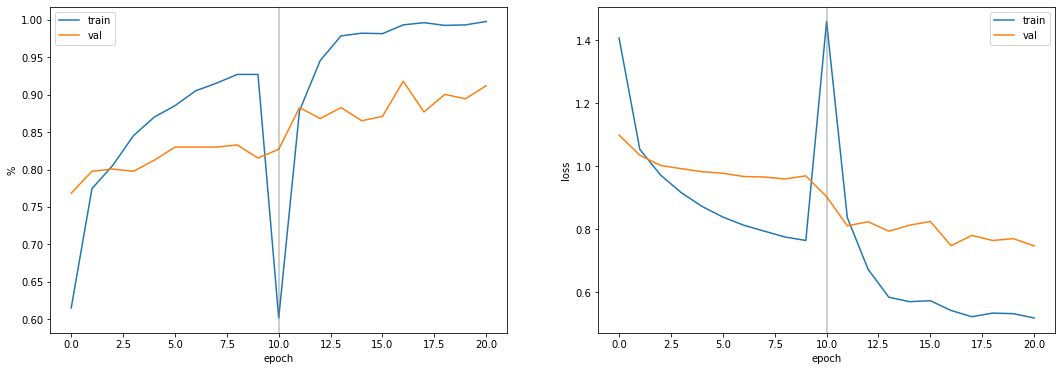

In [87]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
df_history_fine.plot(y=['accuracy', 'val_accuracy'], ylabel='%', xlabel='epoch', ax=axes[0])
axes[0].legend(['train', 'val'])

df_history_fine.plot(y=['loss', 'val_loss'], ylabel='loss', xlabel='epoch', ax=axes[1])
axes[1].legend(['train', 'val'])

for ax in axes:
    ax.axvline(10, color='grey', alpha=0.5)

about 92% accuracy on test set.

In [65]:
model.evaluate(test_ds)

12/12 [==============================] - 2s 133ms/step - loss: 0.7285 - accuracy: 0.9194


[0.7284983396530151, 0.9193548560142517]

checking the confusion matrix

In [114]:
y = np.array([])
for data, y_encoded in test_ds:
    y = np.hstack((y, tf.argmax(y_encoded, axis=1)))

In [118]:
y_hat = tf.argmax(model.predict(test_ds), axis=1)

12/12 [==============================] - 2s 136ms/step


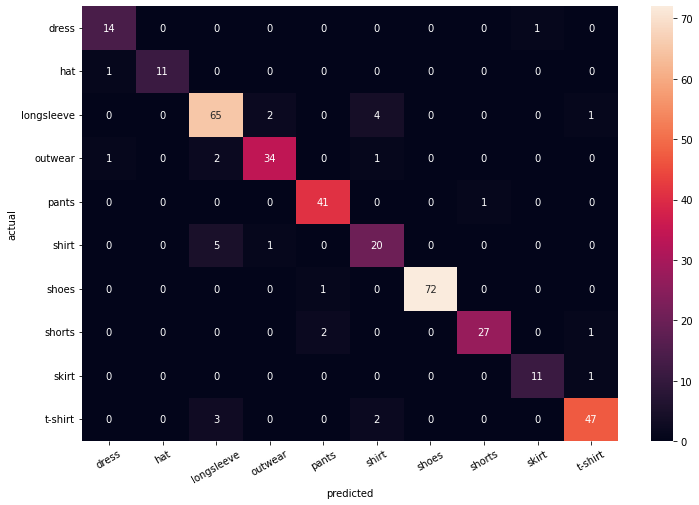

In [149]:
plt.figure(figsize=(12, 8))
cm = tf.math.confusion_matrix(y, y_hat)
ax = sns.heatmap(cm, annot=True)
ax.set_xlabel('predicted')
ax.set_ylabel('actual')
ax.set_xticklabels(classes, rotation=30)
ax.set_yticklabels(classes, rotation=0);